# NB4: Classification - Predicting Strong Rashba Splitting

**Goal:** Classify 2D materials as having strong vs weak Rashba splitting (alpha_R > threshold).

Uses the same best_combo CSVs from nb2/nb3. Tests multiple classifiers with grid search,
multiple thresholds, stratified K-fold + LOO, and handles class imbalance.

## Cell 1: Imports & Setup

In [5]:
import pandas as pd
import numpy as np
import glob
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    StratifiedKFold, LeaveOneOut, GridSearchCV, cross_val_predict
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

# Paths - adjust if needed
STUDY_DIR = "."  # same folder where this notebook lives, with best_combo CSVs
# If CSVs are somewhere else, change this path

## Cell 2: Load All CSVs

In [6]:
csv_files = sorted(glob.glob(os.path.join(STUDY_DIR, "best_combo_*.csv")))
print(f"Found {len(csv_files)} CSV files:")

datasets = {}
for f in csv_files:
    name = os.path.splitext(os.path.basename(f))[0]
    df = pd.read_csv(f)
    datasets[name] = df
    print(f"  {name}: {df.shape[0]} rows, {df.shape[1]} cols -> {list(df.columns)}")

# Quick check: show alpha_R distribution
sample_df = list(datasets.values())[0]
print(f"\nalpha_R stats:\n{sample_df['alpha_R'].describe()}")

Found 6 CSV files:
  best_combo_0_w10_radius_mean: 99 rows, 6 cols -> ['uid', 'Formula', 'alpha_R', 'E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean']
  best_combo_1_w10_radius_mean_max_mass_max_Z: 99 rows, 8 cols -> ['uid', 'Formula', 'alpha_R', 'E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'max_mass', 'max_Z']
  best_combo_2_w10_radius_mean_max_mass_max_Z4: 99 rows, 8 cols -> ['uid', 'Formula', 'alpha_R', 'E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'max_mass', 'max_Z4']
  best_combo_3_w10_radius_mean_max_Z4_max_Z: 99 rows, 8 cols -> ['uid', 'Formula', 'alpha_R', 'E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'max_Z4', 'max_Z']
  best_combo_4_w10_radius_mean_max_mass: 99 rows, 7 cols -> ['uid', 'Formula', 'alpha_R', 'E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'max_mass']
  best_combo_5_w10_radius_mean_radius_diff: 99 rows, 7 cols -> ['uid', 'Formula', 'alpha_R', 'E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'radius_diff']

alpha_R stats:
count    99.000000
mean      1.768394
std       0.96127

## Cell 3: alpha_R Distribution & Threshold Analysis

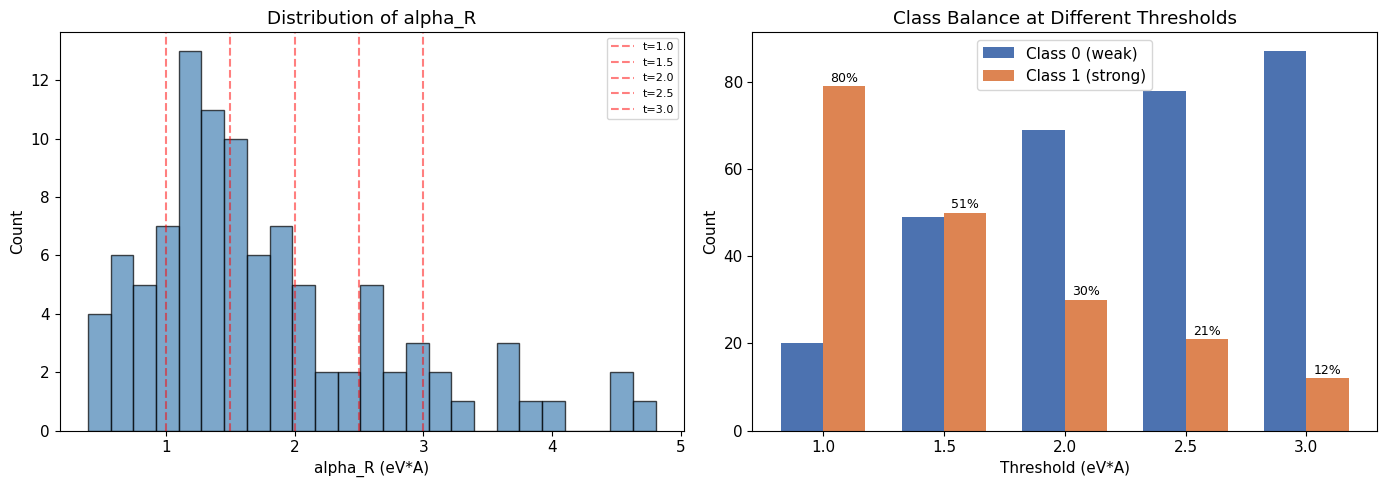


Class balance summary:
 threshold  positive  negative  pct_positive
       1.0        79        20     79.797980
       1.5        50        49     50.505051
       2.0        30        69     30.303030
       2.5        21        78     21.212121
       3.0        12        87     12.121212


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(sample_df['alpha_R'], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('alpha_R (eV*A)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of alpha_R')

# Threshold analysis
thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
class_counts = []
for t in thresholds:
    n_pos = (sample_df['alpha_R'] >= t).sum()
    n_neg = (sample_df['alpha_R'] < t).sum()
    ratio = n_pos / len(sample_df) * 100
    class_counts.append({'threshold': t, 'positive': n_pos, 'negative': n_neg, 'pct_positive': ratio})
    axes[0].axvline(x=t, color='red', linestyle='--', alpha=0.5, label=f't={t}')

axes[0].legend(fontsize=8)

# Class balance bar chart
cc_df = pd.DataFrame(class_counts)
x = np.arange(len(thresholds))
w = 0.35
axes[1].bar(x - w/2, cc_df['negative'], w, label='Class 0 (weak)', color='#4C72B0')
axes[1].bar(x + w/2, cc_df['positive'], w, label='Class 1 (strong)', color='#DD8452')
axes[1].set_xticks(x)
axes[1].set_xticklabels([str(t) for t in thresholds])
axes[1].set_xlabel('Threshold (eV*A)')
axes[1].set_ylabel('Count')
axes[1].set_title('Class Balance at Different Thresholds')
axes[1].legend()
for i, row in cc_df.iterrows():
    axes[1].text(i + w/2, row['positive'] + 1, f"{row['pct_positive']:.0f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nClass balance summary:")
print(cc_df.to_string(index=False))

## Cell 4: Define Models & Grid Search Params

In [8]:
def get_models_and_params():
    """
    Returns dict of model_name -> (estimator, param_grid).
    Grids are kept small enough to run on n=99 without taking forever.
    """
    models = {
        'LogisticRegression': (
            LogisticRegression(max_iter=5000, random_state=42),
            {
                'clf__C': [0.01, 0.1, 1.0, 10.0],
                'clf__penalty': ['l1', 'l2'],
                'clf__solver': ['saga'],
                'clf__class_weight': [None, 'balanced']
            }
        ),
        'SVM_RBF': (
            SVC(probability=True, random_state=42),
            {
                'clf__C': [0.1, 1.0, 10.0, 100.0],
                'clf__gamma': ['scale', 'auto', 0.1],
                'clf__kernel': ['rbf'],
                'clf__class_weight': [None, 'balanced']
            }
        ),
        'SVM_Linear': (
            SVC(probability=True, random_state=42),
            {
                'clf__C': [0.01, 0.1, 1.0, 10.0],
                'clf__kernel': ['linear'],
                'clf__class_weight': [None, 'balanced']
            }
        ),
        'KNN': (
            KNeighborsClassifier(),
            {
                'clf__n_neighbors': [3, 5, 7, 9, 11],
                'clf__weights': ['uniform', 'distance'],
                'clf__metric': ['euclidean', 'manhattan']
            }
        ),
        'DecisionTree': (
            DecisionTreeClassifier(random_state=42),
            {
                'clf__max_depth': [2, 3, 5, 7, None],
                'clf__min_samples_split': [2, 5, 10],
                'clf__class_weight': [None, 'balanced']
            }
        ),
        'RandomForest': (
            RandomForestClassifier(random_state=42),
            {
                'clf__n_estimators': [50, 100, 200],
                'clf__max_depth': [3, 5, 7, None],
                'clf__min_samples_split': [2, 5],
                'clf__class_weight': [None, 'balanced']
            }
        ),
        'GradientBoosting': (
            GradientBoostingClassifier(random_state=42),
            {
                'clf__n_estimators': [50, 100, 200],
                'clf__max_depth': [2, 3, 5],
                'clf__learning_rate': [0.01, 0.1, 0.2],
                'clf__subsample': [0.8, 1.0]
            }
        ),
        'XGBoost': (
            XGBClassifier(
                eval_metric='logloss', use_label_encoder=False,
                random_state=42, verbosity=0
            ),
            {
                'clf__n_estimators': [50, 100, 200],
                'clf__max_depth': [2, 3, 5],
                'clf__learning_rate': [0.01, 0.1, 0.2],
                'clf__reg_alpha': [0, 1.0],
                'clf__reg_lambda': [1.0],
                'clf__scale_pos_weight': [1, 3, 5]
            }
        ),
        'AdaBoost': (
            AdaBoostClassifier(random_state=42),
            {
                'clf__n_estimators': [50, 100, 200],
                'clf__learning_rate': [0.01, 0.1, 0.5, 1.0]
            }
        ),
    }
    return models

print("Models defined:")
for name, (est, params) in get_models_and_params().items():
    n_combos = 1
    for v in params.values():
        n_combos *= len(v)
    print(f"  {name}: {n_combos} grid combos")

Models defined:
  LogisticRegression: 16 grid combos
  SVM_RBF: 24 grid combos
  SVM_Linear: 8 grid combos
  KNN: 20 grid combos
  DecisionTree: 30 grid combos
  RandomForest: 48 grid combos
  GradientBoosting: 54 grid combos
  XGBoost: 162 grid combos
  AdaBoost: 12 grid combos


## Cell 5: Core Evaluation Functions

In [9]:
def evaluate_classification(X, y, model_name, estimator, param_grid, n_splits=5):
    """
    Run stratified K-fold GridSearchCV + LOO evaluation.
    Returns dict with all metrics.
    """
    # Build pipeline with scaler
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', estimator)
    ])

    # --- Stratified K-Fold with GridSearchCV ---
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    grid = GridSearchCV(
        pipe, param_grid, cv=skf, scoring='f1',
        n_jobs=-1, refit=True, error_score=0.0
    )
    grid.fit(X, y)

    best_pipe = grid.best_estimator_
    best_params = grid.best_params_

    # K-Fold predictions using cross_val_predict with best params
    y_pred_kfold = cross_val_predict(best_pipe, X, y, cv=skf)

    # Get probabilities if possible
    try:
        y_prob_kfold = cross_val_predict(best_pipe, X, y, cv=skf, method='predict_proba')[:, 1]
        kfold_auc = roc_auc_score(y, y_prob_kfold)
    except Exception:
        y_prob_kfold = None
        kfold_auc = np.nan

    kfold_acc = accuracy_score(y, y_pred_kfold)
    kfold_prec = precision_score(y, y_pred_kfold, zero_division=0)
    kfold_rec = recall_score(y, y_pred_kfold, zero_division=0)
    kfold_f1 = f1_score(y, y_pred_kfold, zero_division=0)

    # --- Leave-One-Out ---
    loo = LeaveOneOut()
    y_pred_loo = cross_val_predict(best_pipe, X, y, cv=loo)

    try:
        y_prob_loo = cross_val_predict(best_pipe, X, y, cv=loo, method='predict_proba')[:, 1]
        loo_auc = roc_auc_score(y, y_prob_loo)
    except Exception:
        y_prob_loo = None
        loo_auc = np.nan

    loo_acc = accuracy_score(y, y_pred_loo)
    loo_prec = precision_score(y, y_pred_loo, zero_division=0)
    loo_rec = recall_score(y, y_pred_loo, zero_division=0)
    loo_f1 = f1_score(y, y_pred_loo, zero_division=0)

    return {
        'model': model_name,
        'best_params': str(best_params),
        'KF_Acc': kfold_acc, 'KF_Prec': kfold_prec,
        'KF_Rec': kfold_rec, 'KF_F1': kfold_f1, 'KF_AUC': kfold_auc,
        'LOO_Acc': loo_acc, 'LOO_Prec': loo_prec,
        'LOO_Rec': loo_rec, 'LOO_F1': loo_f1, 'LOO_AUC': loo_auc,
        'y_true': y, 'y_pred_kfold': y_pred_kfold, 'y_prob_kfold': y_prob_kfold,
        'y_pred_loo': y_pred_loo, 'y_prob_loo': y_prob_loo
    }

print("Evaluation function ready.")

Evaluation function ready.


## Cell 6: Run All Models x All CSVs x All Thresholds

This is the big loop. For each threshold, for each CSV, for each model: GridSearchCV + LOO.
Takes a while on 99 samples but manageable.

In [10]:
thresholds_to_run = [1.0, 1.5, 2.0, 2.5, 3.0]
NON_FEATURE_COLS = ['uid', 'Formula', 'alpha_R']

all_results = []
detailed_results = {}  # store predictions for later plotting

for thresh in thresholds_to_run:
    print(f"\n{'='*70}")
    print(f"  THRESHOLD = {thresh} eV*A")
    print(f"{'='*70}")

    for csv_name, df in datasets.items():
        # Prepare features and binary target
        feature_cols = [c for c in df.columns if c not in NON_FEATURE_COLS]
        X = df[feature_cols].values
        y_cont = df['alpha_R'].values
        y = (y_cont >= thresh).astype(int)

        n_pos = y.sum()
        n_neg = len(y) - n_pos
        print(f"\n  {csv_name} | Class 1: {n_pos}, Class 0: {n_neg}")

        # Skip if too few in minority class (need at least 5 for stratified 5-fold)
        if min(n_pos, n_neg) < 5:
            print(f"    SKIPPED: minority class has <5 samples")
            continue

        models = get_models_and_params()
        for model_name, (estimator, param_grid) in models.items():
            print(f"    Running {model_name}...", end=" ", flush=True)
            try:
                res = evaluate_classification(X, y, model_name, estimator, param_grid)
                res['csv'] = csv_name
                res['threshold'] = thresh
                res['n_features'] = len(feature_cols)
                res['n_pos'] = n_pos
                res['n_neg'] = n_neg

                # Store detailed preds
                key = (thresh, csv_name, model_name)
                detailed_results[key] = {
                    'y_true': res.pop('y_true'),
                    'y_pred_kfold': res.pop('y_pred_kfold'),
                    'y_prob_kfold': res.pop('y_prob_kfold'),
                    'y_pred_loo': res.pop('y_pred_loo'),
                    'y_prob_loo': res.pop('y_prob_loo')
                }
                all_results.append(res)
                print(f"LOO_F1={res['LOO_F1']:.3f}, LOO_AUC={res['LOO_AUC']:.3f}")
            except Exception as e:
                print(f"FAILED: {e}")
                continue

print(f"\n\nTotal results: {len(all_results)}")


  THRESHOLD = 1.0 eV*A

  best_combo_0_w10_radius_mean | Class 1: 79, Class 0: 20
    Running LogisticRegression... LOO_F1=0.888, LOO_AUC=0.280
    Running SVM_RBF... LOO_F1=0.892, LOO_AUC=0.797
    Running SVM_Linear... LOO_F1=0.888, LOO_AUC=0.365
    Running KNN... LOO_F1=0.877, LOO_AUC=0.746
    Running DecisionTree... LOO_F1=0.899, LOO_AUC=0.749
    Running RandomForest... LOO_F1=0.908, LOO_AUC=0.849
    Running GradientBoosting... LOO_F1=0.908, LOO_AUC=0.769
    Running XGBoost... LOO_F1=0.933, LOO_AUC=0.877
    Running AdaBoost... LOO_F1=0.907, LOO_AUC=0.753

  best_combo_1_w10_radius_mean_max_mass_max_Z | Class 1: 79, Class 0: 20
    Running LogisticRegression... LOO_F1=0.888, LOO_AUC=0.301
    Running SVM_RBF... LOO_F1=0.899, LOO_AUC=0.682
    Running SVM_Linear... LOO_F1=0.888, LOO_AUC=0.361
    Running KNN... LOO_F1=0.884, LOO_AUC=0.584
    Running DecisionTree... LOO_F1=0.897, LOO_AUC=0.784
    Running RandomForest... LOO_F1=0.920, LOO_AUC=0.822
    Running GradientBoosting

## Cell 7: Results DataFrame & Save

In [11]:
df_results = pd.DataFrame(all_results)

# Sort by LOO F1
df_results = df_results.sort_values('LOO_F1', ascending=False).reset_index(drop=True)

# Display top 20
display_cols = ['threshold', 'csv', 'model', 'KF_F1', 'KF_AUC', 'LOO_F1', 'LOO_AUC', 'LOO_Acc', 'LOO_Prec', 'LOO_Rec']
print("Top 20 results by LOO F1:")
print(df_results[display_cols].head(20).to_string(index=False))

# Save full results
df_results.to_csv('classification_full_results.csv', index=False)
print(f"\nSaved classification_full_results.csv ({len(df_results)} rows)")

Top 20 results by LOO F1:
 threshold                                          csv            model    KF_F1   KF_AUC   LOO_F1  LOO_AUC  LOO_Acc  LOO_Prec  LOO_Rec
       1.0                 best_combo_0_w10_radius_mean          XGBoost 0.951807 0.918987 0.933333 0.876582 0.888889  0.895349 0.974684
       1.0 best_combo_2_w10_radius_mean_max_mass_max_Z4          XGBoost 0.951807 0.892722 0.927711 0.877215 0.878788  0.885057 0.974684
       1.0        best_combo_4_w10_radius_mean_max_mass          XGBoost 0.951807 0.892722 0.927711 0.877215 0.878788  0.885057 0.974684
       1.0    best_combo_3_w10_radius_mean_max_Z4_max_Z          XGBoost 0.951807 0.892722 0.927711 0.877215 0.878788  0.885057 0.974684
       1.0  best_combo_1_w10_radius_mean_max_mass_max_Z          XGBoost 0.951807 0.892722 0.927711 0.877215 0.878788  0.885057 0.974684
       1.0        best_combo_4_w10_radius_mean_max_mass     RandomForest 0.933333 0.850633 0.920245 0.823418 0.868687  0.892857 0.949367
       1.0    b

## Cell 8: Best Model per Threshold

In [12]:
print("Best model per threshold (by LOO F1):\n")
best_per_thresh = df_results.loc[df_results.groupby('threshold')['LOO_F1'].idxmax()]
print(best_per_thresh[['threshold', 'csv', 'model', 'KF_F1', 'KF_AUC',
                        'LOO_F1', 'LOO_AUC', 'LOO_Acc', 'LOO_Prec', 'LOO_Rec',
                        'best_params']].to_string(index=False))

Best model per threshold (by LOO F1):

 threshold                                       csv        model    KF_F1   KF_AUC   LOO_F1  LOO_AUC  LOO_Acc  LOO_Prec  LOO_Rec                                                                                                                                         best_params
       1.0              best_combo_0_w10_radius_mean      XGBoost 0.951807 0.918987 0.933333 0.876582 0.888889  0.895349 0.974684 {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1.0, 'clf__scale_pos_weight': 5}
       1.5 best_combo_3_w10_radius_mean_max_Z4_max_Z      XGBoost 0.807692 0.883265 0.849057 0.906531 0.838384  0.803571 0.900000 {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1.0, 'clf__scale_pos_weight': 5}
       2.0 best_combo_3_w10_radius_mean_max_Z4_max_Z      SVM_RBF 0.777778 0.882609 0.754717 0.871014 0.868687  0.869565 0.6666

## Cell 9: Best Model per CSV (across all thresholds)

In [13]:
print("Best model per CSV (by LOO F1):\n")
best_per_csv = df_results.loc[df_results.groupby('csv')['LOO_F1'].idxmax()]
print(best_per_csv[['csv', 'threshold', 'model', 'KF_F1', 'KF_AUC',
                     'LOO_F1', 'LOO_AUC', 'n_features']].to_string(index=False))

Best model per CSV (by LOO F1):

                                         csv  threshold   model    KF_F1   KF_AUC   LOO_F1  LOO_AUC  n_features
                best_combo_0_w10_radius_mean        1.0 XGBoost 0.951807 0.918987 0.933333 0.876582           3
 best_combo_1_w10_radius_mean_max_mass_max_Z        1.0 XGBoost 0.951807 0.892722 0.927711 0.877215           5
best_combo_2_w10_radius_mean_max_mass_max_Z4        1.0 XGBoost 0.951807 0.892722 0.927711 0.877215           5
   best_combo_3_w10_radius_mean_max_Z4_max_Z        1.0 XGBoost 0.951807 0.892722 0.927711 0.877215           5
       best_combo_4_w10_radius_mean_max_mass        1.0 XGBoost 0.951807 0.892722 0.927711 0.877215           4
    best_combo_5_w10_radius_mean_radius_diff        1.0 XGBoost 0.951807 0.913291 0.914634 0.869620           4


## Cell 10: Heatmap - LOO F1 (Model x Threshold) for best CSV at threshold 1.5

Heatmap for best CSV at threshold 1.5: best_combo_3_w10_radius_mean_max_Z4_max_Z



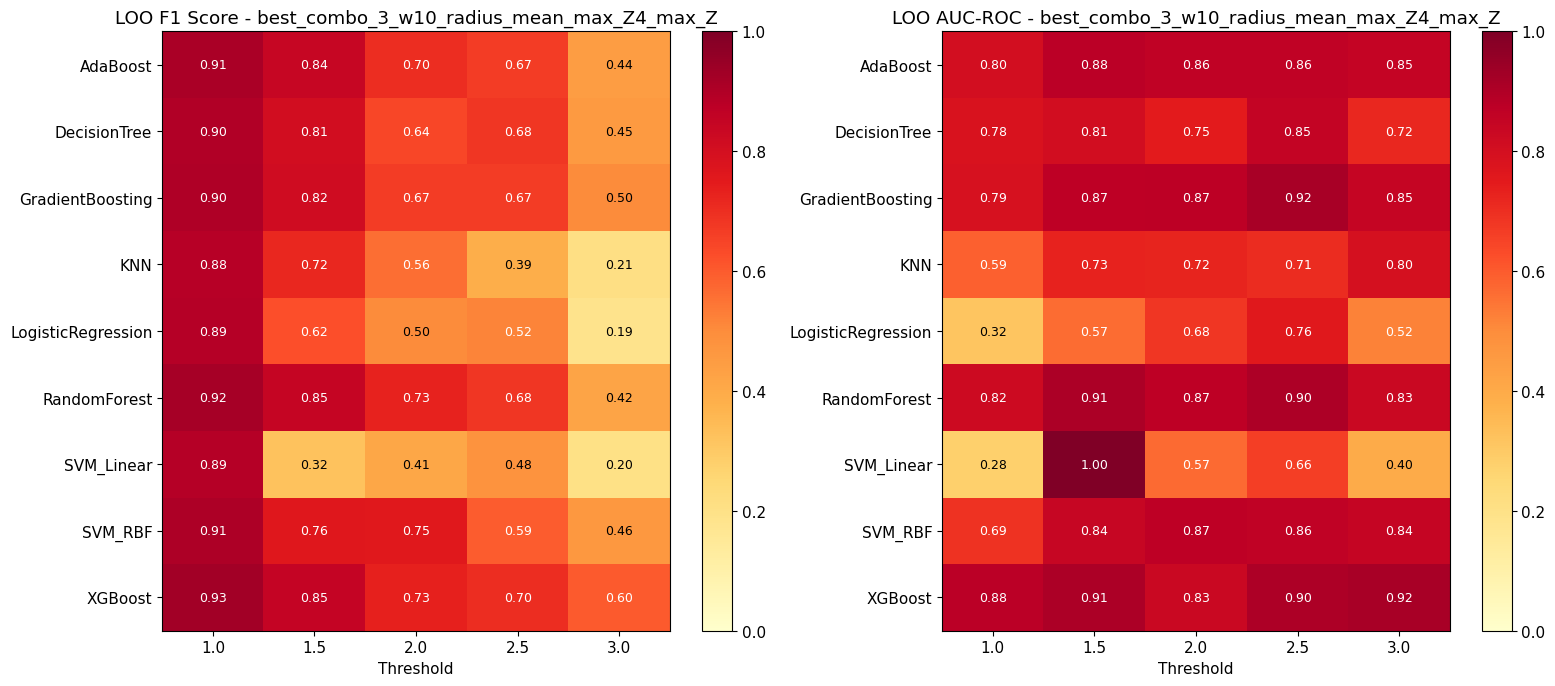

In [22]:
# Use the CSV that gave best LOO F1 at threshold 1.5
df_thresh_15 = df_results[df_results['threshold'] == 1.5]
best_csv = df_thresh_15.iloc[0]['csv']
print(f"Heatmap for best CSV at threshold 1.5: {best_csv}\n")

subset = df_results[df_results['csv'] == best_csv]
pivot_f1 = subset.pivot_table(index='model', columns='threshold', values='LOO_F1', aggfunc='max')
pivot_auc = subset.pivot_table(index='model', columns='threshold', values='LOO_AUC', aggfunc='max')

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# F1 heatmap
im1 = axes[0].imshow(pivot_f1.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
axes[0].set_xticks(range(len(pivot_f1.columns)))
axes[0].set_xticklabels([f'{c:.1f}' for c in pivot_f1.columns])
axes[0].set_yticks(range(len(pivot_f1.index)))
axes[0].set_yticklabels(pivot_f1.index)
axes[0].set_xlabel('Threshold')
axes[0].set_title(f'LOO F1 Score - {best_csv}')
for i in range(len(pivot_f1.index)):
    for j in range(len(pivot_f1.columns)):
        val = pivot_f1.values[i, j]
        if not np.isnan(val):
            axes[0].text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=9,
                        color='white' if val > 0.5 else 'black')
plt.colorbar(im1, ax=axes[0])

# AUC heatmap
im2 = axes[1].imshow(pivot_auc.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
axes[1].set_xticks(range(len(pivot_auc.columns)))
axes[1].set_xticklabels([f'{c:.1f}' for c in pivot_auc.columns])
axes[1].set_yticks(range(len(pivot_auc.index)))
axes[1].set_yticklabels(pivot_auc.index)
axes[1].set_xlabel('Threshold')
axes[1].set_title(f'LOO AUC-ROC - {best_csv}')
for i in range(len(pivot_auc.index)):
    for j in range(len(pivot_auc.columns)):
        val = pivot_auc.values[i, j]
        if not np.isnan(val):
            axes[1].text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=9,
                        color='white' if val > 0.5 else 'black')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.savefig('heatmap_classification.png', dpi=150, bbox_inches='tight')
plt.show()

## Cell 11: Confusion Matrices for Top 4 at threshold 1.5

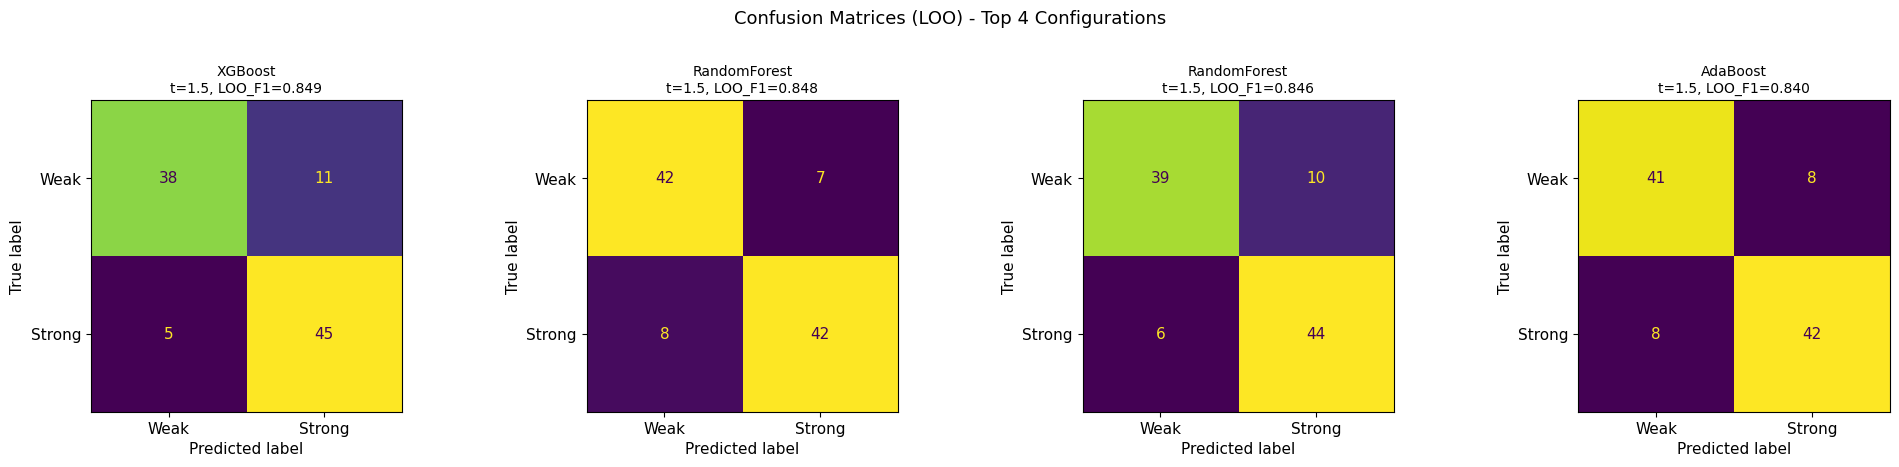

In [23]:
df_thresh_15 = df_results[df_results['threshold'] == 1.5]
top4 = df_thresh_15.head(4)
fig, axes = plt.subplots(1, 4, figsize=(20, 4.5))

for idx, (_, row) in enumerate(top4.iterrows()):
    key = (row['threshold'], row['csv'], row['model'])
    det = detailed_results[key]

    cm = confusion_matrix(det['y_true'], det['y_pred_loo'])
    ConfusionMatrixDisplay(cm, display_labels=['Weak', 'Strong']).plot(ax=axes[idx], colorbar=False)
    axes[idx].set_title(f"{row['model']}\nt={row['threshold']}, LOO_F1={row['LOO_F1']:.3f}", fontsize=10)

plt.suptitle('Confusion Matrices (LOO) - Top 4 Configurations', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices_top4.png', dpi=150, bbox_inches='tight')
plt.show()

## Cell 12: ROC Curves for Top 4 at threshold 1.5

In [24]:
df_thresh_15 = df_results[df_results['threshold'] == 1.5]
top4_roc = df_thresh_15.head(4)

fig, ax = plt.subplots(figsize=(8, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (_, row) in enumerate(top4_roc.iterrows()):
    key = (row['threshold'], row['csv'], row['model'])
    det = detailed_results[key]

    if det['y_prob_loo'] is not None:
        fpr, tpr, _ = roc_curve(det['y_true'], det['y_prob_loo'])
        roc_auc_val = auc(fpr, tpr)
        label = f"{row['model']} (t={row['threshold']}) AUC={roc_auc_val:.3f}"
        ax.plot(fpr, tpr, color=colors[idx], lw=2, label=label)

ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves (LOO) - Top 4 Configurations')
ax.legend(loc='lower right', fontsize=9)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

plt.tight_layout()plt.show()
plt.savefig('roc_curves_top4.png', dpi=150, bbox_inches='tight')

SyntaxError: invalid syntax (1831191958.py, line 25)

## Cell 13: Threshold Comparison - Average LOO F1 across all models

Threshold comparison (averaged across all models and CSVs):
 threshold  mean_F1   max_F1  mean_AUC  max_AUC  mean_Acc  n_runs
       1.0 0.901018 0.933333  0.684300 0.877215  0.832211      54
       1.5 0.717867 0.849057  0.823416 1.000000  0.696034      54
       2.0 0.641827 0.754717  0.786997 0.894686  0.767303      54
       2.5 0.605364 0.750000  0.801457 0.930403  0.820801      54
       3.0 0.396924 0.642857  0.741353 0.918582  0.815750      54


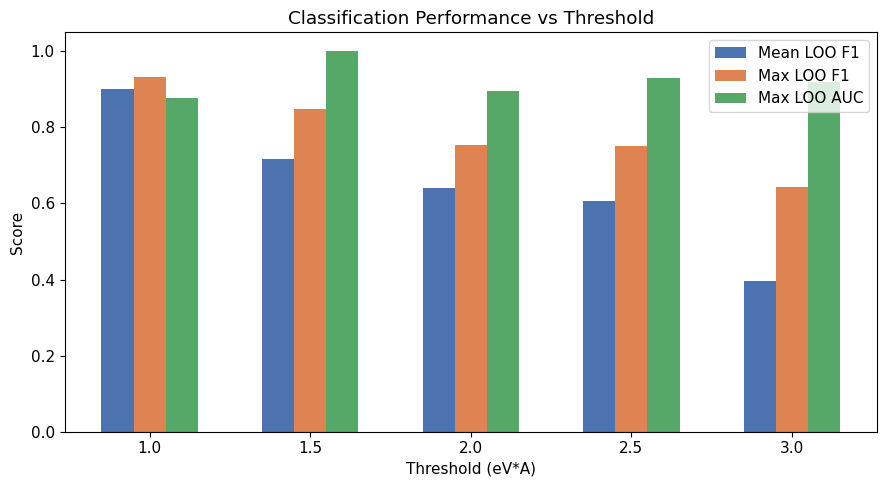

In [17]:
thresh_summary = df_results.groupby('threshold').agg(
    mean_F1=('LOO_F1', 'mean'),
    max_F1=('LOO_F1', 'max'),
    mean_AUC=('LOO_AUC', 'mean'),
    max_AUC=('LOO_AUC', 'max'),
    mean_Acc=('LOO_Acc', 'mean'),
    n_runs=('LOO_F1', 'count')
).reset_index()

print("Threshold comparison (averaged across all models and CSVs):")
print(thresh_summary.to_string(index=False))

fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(thresh_summary))
w = 0.2
ax.bar(x - w, thresh_summary['mean_F1'], w, label='Mean LOO F1', color='#4C72B0')
ax.bar(x, thresh_summary['max_F1'], w, label='Max LOO F1', color='#DD8452')
ax.bar(x + w, thresh_summary['max_AUC'], w, label='Max LOO AUC', color='#55A868')

ax.set_xticks(x)
ax.set_xticklabels([f'{t:.1f}' for t in thresh_summary['threshold']])
ax.set_xlabel('Threshold (eV*A)')
ax.set_ylabel('Score')
ax.set_title('Classification Performance vs Threshold')
ax.legend()
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig('threshold_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Cell 14: KFold vs LOO Comparison (Top 10 at threshold 1.5)

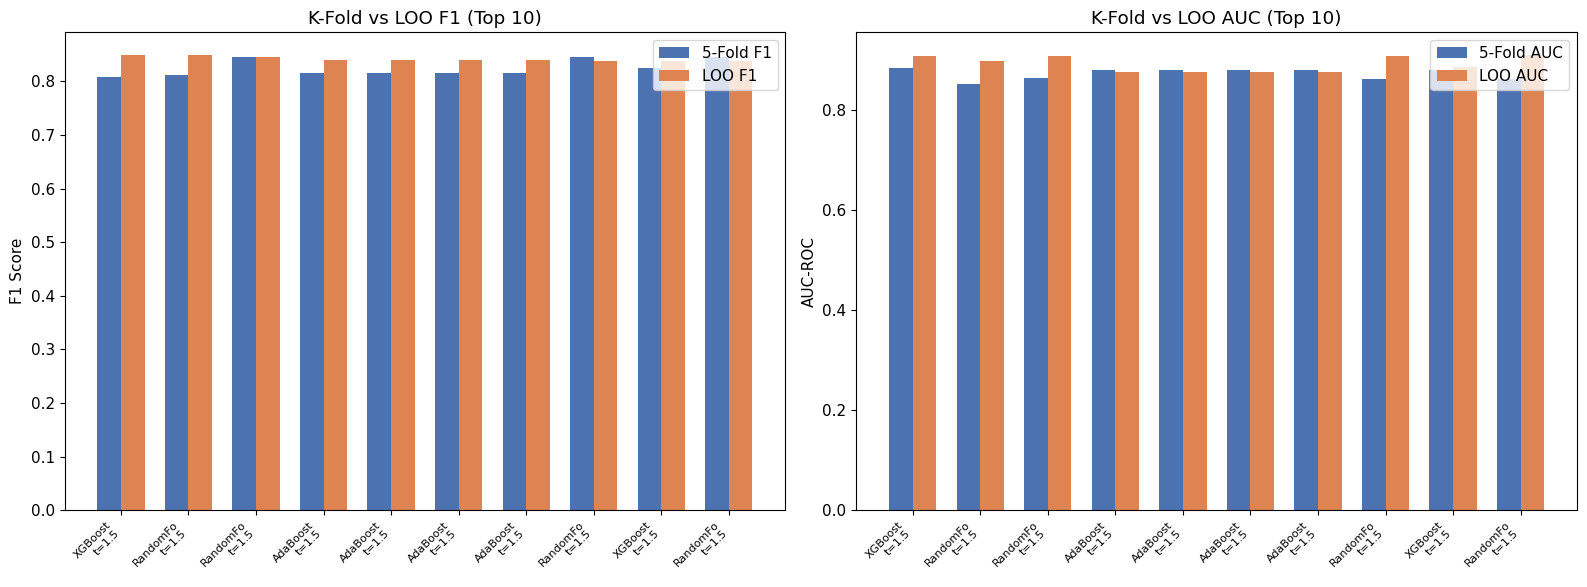

In [25]:
df_thresh_15 = df_results[df_results['threshold'] == 1.5]
top10 = df_thresh_15.head(10).copy()
top10['label'] = top10.apply(lambda r: f"{r['model'][:8]}\nt={r['threshold']}", axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 comparison
x = np.arange(len(top10))
w = 0.35
axes[0].bar(x - w/2, top10['KF_F1'], w, label='5-Fold F1', color='#4C72B0')
axes[0].bar(x + w/2, top10['LOO_F1'], w, label='LOO F1', color='#DD8452')
axes[0].set_xticks(x)
axes[0].set_xticklabels(top10['label'], rotation=45, ha='right', fontsize=8)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('K-Fold vs LOO F1 (Top 10)')
axes[0].legend()

# AUC comparison
axes[1].bar(x - w/2, top10['KF_AUC'], w, label='5-Fold AUC', color='#4C72B0')
axes[1].bar(x + w/2, top10['LOO_AUC'], w, label='LOO AUC', color='#DD8452')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top10['label'], rotation=45, ha='right', fontsize=8)
axes[1].set_ylabel('AUC-ROC')
axes[1].set_title('K-Fold vs LOO AUC (Top 10)')
axes[1].legend()

plt.tight_layout()
plt.savefig('kfold_vs_loo_classification.png', dpi=150, bbox_inches='tight')
plt.show()

## Cell 15: Detailed Report for Best Configuration at threshold 1.5

In [26]:
df_thresh_15 = df_results[df_results['threshold'] == 1.5]
best_row = df_thresh_15.iloc[0]
best_key = (best_row['threshold'], best_row['csv'], best_row['model'])
best_det = detailed_results[best_key]

print(f"{'='*60}")
print(f"  BEST CONFIGURATION")
print(f"{'='*60}")
print(f"  Model:     {best_row['model']}")
print(f"  CSV:       {best_row['csv']}")
print(f"  Threshold: {best_row['threshold']} eV*A")
print(f"  Features:  {best_row['n_features']}")
print(f"  Class balance: {best_row['n_pos']} positive, {best_row['n_neg']} negative")
print(f"  Best params: {best_row['best_params']}")
print(f"\n  --- 5-Fold CV ---")
print(f"  Accuracy:  {best_row['KF_Acc']:.4f}")
print(f"  Precision: {best_row['KF_Prec']:.4f}")
print(f"  Recall:    {best_row['KF_Rec']:.4f}")
print(f"  F1:        {best_row['KF_F1']:.4f}")
print(f"  AUC-ROC:   {best_row['KF_AUC']:.4f}")
print(f"\n  --- Leave-One-Out ---")
print(f"  Accuracy:  {best_row['LOO_Acc']:.4f}")
print(f"  Precision: {best_row['LOO_Prec']:.4f}")
print(f"  Recall:    {best_row['LOO_Rec']:.4f}")
print(f"  F1:        {best_row['LOO_F1']:.4f}")
print(f"  AUC-ROC:   {best_row['LOO_AUC']:.4f}")

print(f"\nClassification Report (LOO):")
print(classification_report(best_det['y_true'], best_det['y_pred_loo'],
                            target_names=['Weak Rashba', 'Strong Rashba']))

  BEST CONFIGURATION
  Model:     XGBoost
  CSV:       best_combo_3_w10_radius_mean_max_Z4_max_Z
  Threshold: 1.5 eV*A
  Features:  5
  Class balance: 50 positive, 49 negative
  Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1.0, 'clf__scale_pos_weight': 5}

  --- 5-Fold CV ---
  Accuracy:  0.7980
  Precision: 0.7778
  Recall:    0.8400
  F1:        0.8077
  AUC-ROC:   0.8833

  --- Leave-One-Out ---
  Accuracy:  0.8384
  Precision: 0.8036
  Recall:    0.9000
  F1:        0.8491
  AUC-ROC:   0.9065

Classification Report (LOO):
               precision    recall  f1-score   support

  Weak Rashba       0.88      0.78      0.83        49
Strong Rashba       0.80      0.90      0.85        50

     accuracy                           0.84        99
    macro avg       0.84      0.84      0.84        99
 weighted avg       0.84      0.84      0.84        99



## Cell 16: Feature Importance for Best Tree-Based Model at threshold 1.5

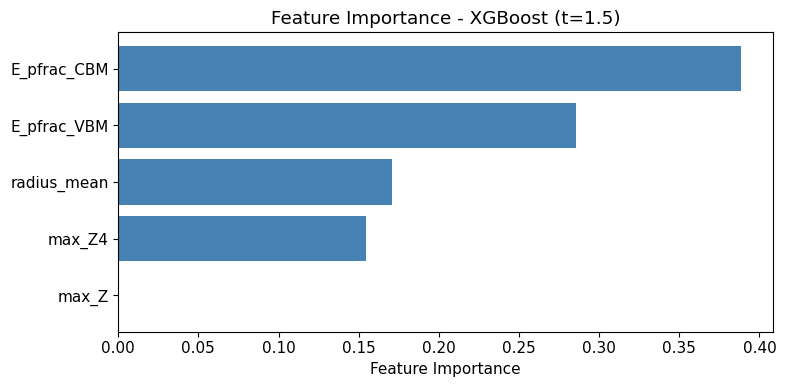


Feature importances:
    feature  importance
E_pfrac_CBM    0.388815
E_pfrac_VBM    0.285507
radius_mean    0.170872
     max_Z4    0.154806
      max_Z    0.000000


In [27]:
# Find the best tree-based model for feature importance at threshold 1.5
df_thresh_15 = df_results[df_results['threshold'] == 1.5]
tree_models = ['RandomForest', 'XGBoost', 'GradientBoosting', 'DecisionTree', 'AdaBoost']
tree_results = df_thresh_15[df_thresh_15['model'].isin(tree_models)]

if len(tree_results) > 0:
    best_tree = tree_results.iloc[0]
    best_tree_key = (best_tree['threshold'], best_tree['csv'], best_tree['model'])

    # Retrain the best tree model on full data to get feature importance
    csv_df = datasets[best_tree['csv']]
    feature_cols = [c for c in csv_df.columns if c not in NON_FEATURE_COLS]
    X_full = csv_df[feature_cols].values
    y_full = (csv_df['alpha_R'].values >= best_tree['threshold']).astype(int)

    # Parse best params back
    bp = eval(best_tree['best_params'])
    # Rebuild the model with best params
    models = get_models_and_params()
    est, _ = models[best_tree['model']]
    for k, v in bp.items():
        param_name = k.replace('clf__', '')
        if hasattr(est, param_name):
            setattr(est, param_name, v)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)
    est.fit(X_scaled, y_full)

    importances = est.feature_importances_
    feat_imp = pd.DataFrame({'feature': feature_cols, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=True)

    fig, ax = plt.subplots(figsize=(8, max(4, len(feature_cols) * 0.5)))
    ax.barh(feat_imp['feature'], feat_imp['importance'], color='steelblue')
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Feature Importance - {best_tree["model"]} (t={best_tree["threshold"]})')
    plt.tight_layout()
    plt.savefig('feature_importance_classification.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nFeature importances:")
    print(feat_imp.sort_values('importance', ascending=False).to_string(index=False))
else:
    print("No tree-based models in results.")

## Cell 17: Summary Table

In [21]:
print("\n" + "="*70)
print("  FINAL SUMMARY")
print("="*70)

print("\nBest per threshold:")
for _, row in best_per_thresh.iterrows():
    print(f"  t={row['threshold']:.1f}: {row['model']} on {row['csv']} "
          f"-> LOO_F1={row['LOO_F1']:.3f}, LOO_AUC={row['LOO_AUC']:.3f}")

print(f"\nOverall best: {df_results.iloc[0]['model']} at threshold {df_results.iloc[0]['threshold']} "
      f"on {df_results.iloc[0]['csv']}")
print(f"  LOO F1  = {df_results.iloc[0]['LOO_F1']:.4f}")
print(f"  LOO AUC = {df_results.iloc[0]['LOO_AUC']:.4f}")
print(f"  LOO Acc = {df_results.iloc[0]['LOO_Acc']:.4f}")

print(f"\nTotal configurations tested: {len(df_results)}")
print(f"Saved: classification_full_results.csv")
print(f"Plots: heatmap_classification.png, confusion_matrices_top4.png,")
print(f"       roc_curves_top4.png, threshold_comparison.png,")
print(f"       kfold_vs_loo_classification.png, feature_importance_classification.png")


  FINAL SUMMARY

Best per threshold:
  t=1.0: XGBoost on best_combo_0_w10_radius_mean -> LOO_F1=0.933, LOO_AUC=0.877
  t=1.5: XGBoost on best_combo_3_w10_radius_mean_max_Z4_max_Z -> LOO_F1=0.849, LOO_AUC=0.907
  t=2.0: SVM_RBF on best_combo_3_w10_radius_mean_max_Z4_max_Z -> LOO_F1=0.755, LOO_AUC=0.871
  t=2.5: AdaBoost on best_combo_4_w10_radius_mean_max_mass -> LOO_F1=0.750, LOO_AUC=0.876
  t=3.0: DecisionTree on best_combo_4_w10_radius_mean_max_mass -> LOO_F1=0.643, LOO_AUC=0.829

Overall best: XGBoost at threshold 1.0 on best_combo_0_w10_radius_mean
  LOO F1  = 0.9333
  LOO AUC = 0.8766
  LOO Acc = 0.8889

Total configurations tested: 270
Saved: classification_full_results.csv
Plots: heatmap_classification.png, confusion_matrices_top4.png,
       roc_curves_top4.png, threshold_comparison.png,
       kfold_vs_loo_classification.png, feature_importance_classification.png


## Cell 18: Run Evaluation for Threshold 1.25 (No Visuals)

This cell runs the full evaluation pipeline ONLY for threshold 1.25, without re-running the other thresholds.

In [29]:
# Run evaluation for threshold 1.25
thresh = 1.25
NON_FEATURE_COLS = ['uid', 'Formula', 'alpha_R']

new_results_125 = []
new_detailed_125 = {}

print(f"\n{'='*70}")
print(f"  RUNNING THRESHOLD = {thresh} eV*A")
print(f"{'='*70}")

for csv_name, df in datasets.items():
    # Prepare features and binary target
    feature_cols = [c for c in df.columns if c not in NON_FEATURE_COLS]
    X = df[feature_cols].values
    y_cont = df['alpha_R'].values
    y = (y_cont >= thresh).astype(int)

    n_pos = y.sum()
    n_neg = len(y) - n_pos
    print(f"\n  {csv_name} | Class 1: {n_pos}, Class 0: {n_neg}")

    # Skip if too few in minority class
    if min(n_pos, n_neg) < 5:
        print(f"    SKIPPED: minority class has <5 samples")
        continue

    models = get_models_and_params()
    for model_name, (estimator, param_grid) in models.items():
        print(f"    Running {model_name}...", end=" ", flush=True)
        try:
            res = evaluate_classification(X, y, model_name, estimator, param_grid)
            res['csv'] = csv_name
            res['threshold'] = thresh
            res['n_features'] = len(feature_cols)
            res['n_pos'] = n_pos
            res['n_neg'] = n_neg

            # Store detailed preds
            key = (thresh, csv_name, model_name)
            new_detailed_125[key] = {
                'y_true': res.pop('y_true'),
                'y_pred_kfold': res.pop('y_pred_kfold'),
                'y_prob_kfold': res.pop('y_prob_kfold'),
                'y_pred_loo': res.pop('y_pred_loo'),
                'y_prob_loo': res.pop('y_prob_loo')
            }
            new_results_125.append(res)
            print(f"LOO_F1={res['LOO_F1']:.3f}, LOO_AUC={res['LOO_AUC']:.3f}")
        except Exception as e:
            print(f"FAILED: {e}")
            continue

print(f"\n\nNew results at threshold 1.25: {len(new_results_125)}")

# Add to existing results
all_results.extend(new_results_125)
detailed_results.update(new_detailed_125)

# Update df_results
df_results = pd.DataFrame(all_results)
df_results = df_results.sort_values('LOO_F1', ascending=False).reset_index(drop=True)

# Save updated results
df_results.to_csv('classification_full_results.csv', index=False)
print(f"Updated classification_full_results.csv ({len(df_results)} rows)")

# Display results for threshold 1.25
print("\n" + "="*70)
print("  THRESHOLD 1.25 eV*A - TOP 10 RESULTS")
print("="*70)

df_thresh_125 = df_results[df_results['threshold'] == 1.25]
top10_125 = df_thresh_125.head(10)
display_cols_125 = ['csv', 'model', 'LOO_F1', 'LOO_AUC', 'LOO_Acc', 'LOO_Prec', 'LOO_Rec', 'KF_F1', 'KF_AUC']
print("\nTop 10 models at threshold 1.25:")
print(top10_125[display_cols_125].to_string(index=False))

best_125 = df_thresh_125.iloc[0]
print(f"\n{'='*70}")
print(f"  BEST MODEL AT THRESHOLD 1.25")
print(f"{'='*70}")
print(f"  Model:     {best_125['model']}")
print(f"  CSV:       {best_125['csv']}")
print(f"  Features:  {best_125['n_features']}")
print(f"  Class balance: {best_125['n_pos']} positive, {best_125['n_neg']} negative")
print(f"  Best params: {best_125['best_params']}")
print(f"\n  LOO Metrics:")
print(f"    F1:        {best_125['LOO_F1']:.4f}")
print(f"    AUC:       {best_125['LOO_AUC']:.4f}")
print(f"    Accuracy:  {best_125['LOO_Acc']:.4f}")
print(f"    Precision: {best_125['LOO_Prec']:.4f}")
print(f"    Recall:    {best_125['LOO_Rec']:.4f}")
print(f"\n  5-Fold CV Metrics:")
print(f"    F1:        {best_125['KF_F1']:.4f}")
print(f"    AUC:       {best_125['KF_AUC']:.4f}")
print(f"    Accuracy:  {best_125['KF_Acc']:.4f}")

# Statistics across all models at 1.25
print(f"\n  Summary Statistics (all models at t=1.25):")
print(f"    Mean LOO F1:  {df_thresh_125['LOO_F1'].mean():.4f}")
print(f"    Std LOO F1:   {df_thresh_125['LOO_F1'].std():.4f}")
print(f"    Max LOO F1:   {df_thresh_125['LOO_F1'].max():.4f}")
print(f"    Min LOO F1:   {df_thresh_125['LOO_F1'].min():.4f}")
print(f"    Mean LOO AUC: {df_thresh_125['LOO_AUC'].mean():.4f}")
print(f"    Total models: {len(df_thresh_125)}")


  RUNNING THRESHOLD = 1.25 eV*A

  best_combo_0_w10_radius_mean | Class 1: 67, Class 0: 32
    Running LogisticRegression... LOO_F1=0.807, LOO_AUC=0.440
    Running SVM_RBF... LOO_F1=0.807, LOO_AUC=0.478
    Running SVM_Linear... LOO_F1=0.807, LOO_AUC=0.167
    Running KNN... LOO_F1=0.811, LOO_AUC=0.787
    Running DecisionTree... LOO_F1=0.818, LOO_AUC=0.764
    Running RandomForest... LOO_F1=0.844, LOO_AUC=0.876
    Running GradientBoosting... LOO_F1=0.889, LOO_AUC=0.872
    Running XGBoost... LOO_F1=0.878, LOO_AUC=0.887
    Running AdaBoost... LOO_F1=0.866, LOO_AUC=0.839

  best_combo_1_w10_radius_mean_max_mass_max_Z | Class 1: 67, Class 0: 32
    Running LogisticRegression... LOO_F1=0.807, LOO_AUC=0.423
    Running SVM_RBF... LOO_F1=0.807, LOO_AUC=0.127
    Running SVM_Linear... LOO_F1=0.807, LOO_AUC=0.063
    Running KNN... LOO_F1=0.767, LOO_AUC=0.538
    Running DecisionTree... LOO_F1=0.824, LOO_AUC=0.601
    Running RandomForest... LOO_F1=0.849, LOO_AUC=0.834
    Running Gradien